Source
https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import datetime
import IPython
import IPython.display

# Data preperation

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

### Create data frame from input file

In [3]:
df = pd.read_csv('building_data.csv').interpolate()
df['Time'] = pd.to_datetime(df['Time'], infer_datetime_format=True)

In [4]:
df

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Office_Elizabeth,Office_Ellie,Office_Evelyn,Office_Eileen,Office_Bobbi,Office_Benjamin,Office_Bianca,Office_Benthe,Office_Brian,Office_Bryon
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,3.163383,6.970150,240.968342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,3.170692,6.780483,142.524367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,3.186217,6.970150,160.405408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,3.159733,6.685650,155.820508,NaN,41.775,44.75,19.56675,142.25,73.82075,273.150
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,3.167025,6.922733,150.711650,NaN,42.525,42.25,17.51600,143.00,74.88975,267.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,11.650250,31.958475,272.997017,64.280192,46.025,54.00,19.69750,135.50,79.16700,238.175
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.050,54.00,18.84550,137.00,79.64075,244.500
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,46.450,53.25,19.05500,138.25,79.99925,246.450
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.075,54.00,20.61675,141.50,85.80275,238.500


### Create aggregated data frame

In [5]:
df["Power consumption (kWh)"] = df.iloc[:,5:].mean(axis=1, skipna=True)
aggregated = df.drop(df.columns[5:-1], axis=1)

In [6]:
# Swap order so that
aggregated = aggregated.reindex(['Time', 'Day', 'Price( $ per kWh)', 'PV (W)', 'Temperature in LA in 2012 (Celsius)', 'Power consumption (kWh)'], axis=1)

In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

aggregated = filter_rows_by_values(aggregated, "Power consumption (kWh)", [0])


In [8]:
aggregated

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,83.700625
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,50.825181
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,56.853925
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,84.553155
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,83.211906
...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,95.345043
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,96.461049
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,97.002849
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,97.106874


### Add time variables

In [9]:
aggregated.insert(2, 'Day of Week', aggregated['Day'], True)
aggregated.insert(1, 'Year', aggregated['Time'].map(lambda x: x.year), True)
aggregated.insert(2, 'Day of Year', aggregated['Time'].map(lambda x: x.dayofyear), True)
aggregated.drop('Day', axis=1, inplace=True)
aggregated.insert(3, 'Hour', aggregated['Time'].map(lambda x: x.hour), True)

In [10]:
aggregated

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,2012,1,5,Sunday,0.08283,0.000,11.1,83.700625
1,2012-01-01 06:00:00+00:00,2012,1,6,Sunday,0.08283,0.000,10.0,50.825181
2,2012-01-01 07:00:00+00:00,2012,1,7,Sunday,0.08283,0.000,10.0,56.853925
3,2012-01-01 08:00:00+00:00,2012,1,8,Sunday,0.08283,743.711,10.0,84.553155
4,2012-01-01 09:00:00+00:00,2012,1,9,Sunday,0.08283,1479.480,10.0,83.211906
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,2012,366,19,Monday,0.09690,0.000,14.4,95.345043
8775,2012-12-31 20:00:00+00:00,2012,366,20,Monday,0.09690,0.000,15.0,96.461049
8776,2012-12-31 21:00:00+00:00,2012,366,21,Monday,0.08283,0.000,15.0,97.002849
8777,2012-12-31 22:00:00+00:00,2012,366,22,Monday,0.08283,0.000,15.0,97.106874


### Encode and Scale data

In [11]:
# encode categorical data
encoder = LabelEncoder()
encoding_columns = ["Day of Week"]
for column in encoding_columns:
    aggregated[column] = encoder.fit_transform(aggregated[column]).astype('float32')

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
# these columns are NOT scaled
scalable_columns = aggregated.columns.difference(["Time"])
aggregated[scalable_columns] = scaler.fit_transform(aggregated[scalable_columns])

### Resulting prepared data

In [13]:
prepared_data = aggregated.reset_index(inplace=False, drop=True)
prepared_data

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,0.0,0.0,0.217391,0.500000,0.028415,0.000000,0.549433,0.309313
1,2012-01-01 06:00:00+00:00,0.0,0.0,0.260870,0.500000,0.028415,0.000000,0.531605,0.000000
2,2012-01-01 07:00:00+00:00,0.0,0.0,0.304348,0.500000,0.028415,0.000000,0.531605,0.056722
3,2012-01-01 08:00:00+00:00,0.0,0.0,0.347826,0.500000,0.028415,0.223776,0.531605,0.317334
4,2012-01-01 09:00:00+00:00,0.0,0.0,0.391304,0.500000,0.028415,0.445162,0.531605,0.304715
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,0.0,1.0,0.826087,0.166667,0.090592,0.000000,0.602917,0.418871
8775,2012-12-31 20:00:00+00:00,0.0,1.0,0.869565,0.166667,0.090592,0.000000,0.612642,0.429371
8776,2012-12-31 21:00:00+00:00,0.0,1.0,0.913043,0.166667,0.028415,0.000000,0.612642,0.434469
8777,2012-12-31 22:00:00+00:00,0.0,1.0,0.956522,0.166667,0.028415,0.000000,0.612642,0.435447


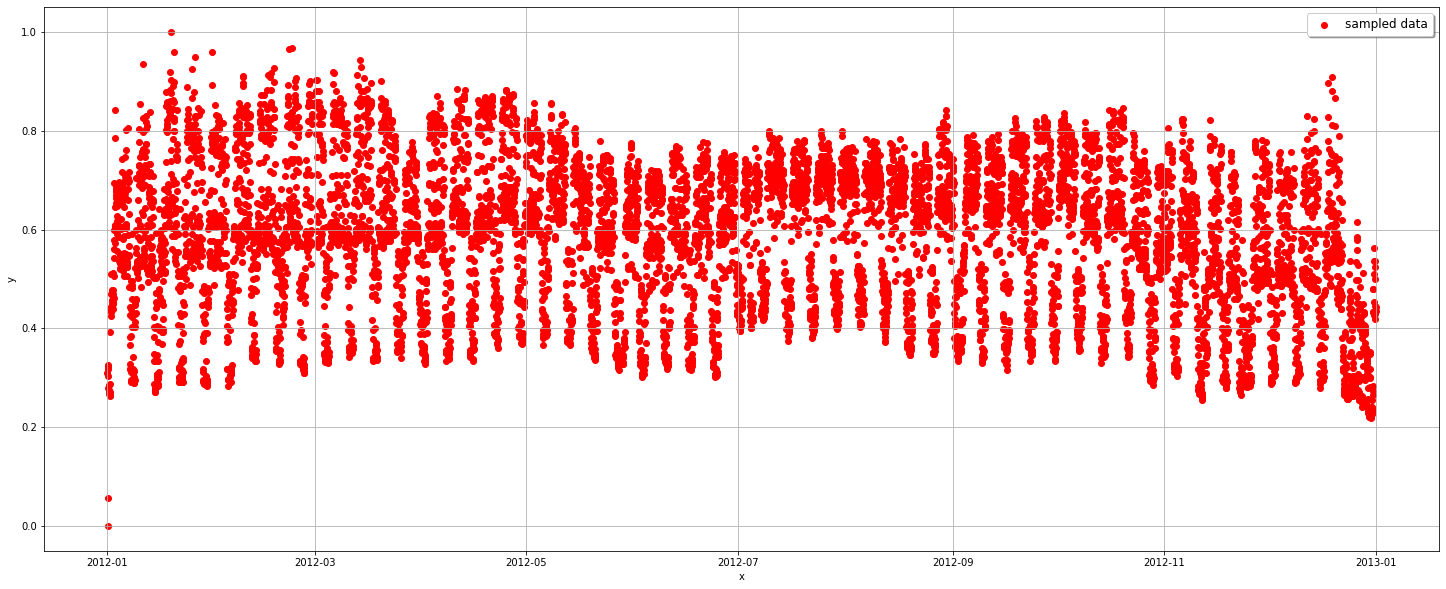

In [14]:
# Graph of prepared data (graph repeated later)
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(prepared_data.loc[:,'Time'],prepared_data.loc[:,'Power consumption (kWh)'],c="r",label='sampled data')
ax.legend(fontsize='large',shadow=True, bbox_to_anchor=(1, 1))
plt.show()

# Model Tools

## Imports

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
from sklearn.utils import shuffle
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input

## Constants

In [16]:
MEASURE_COLUMN_NAME = "Day of Year"
TRAINING_DATA_DECIMAL = 0.7
VALIDATION_DATA_DECIMAL = 0.2
TEST_DATA_DECIMAL = 0.1

In [17]:
# The number of timesteps to be used as input
INPUT_STEP_COUNT = 24 # input_width
# The number of timesteps to be used as output
OUTPUT_STEP_COUNT = 24 # label_width
# The column(s) to be predicted
OUTPUT_COLUMN_NAMES = ["Power consumption (kWh)"] # label_columns
PRIMARY_OUTPUT_COLUMN = OUTPUT_COLUMN_NAMES[0]

In [18]:
# The column(s) to ignore
IGNORE_COLUMN_NAMES = ["Year", "Time"]

In [19]:
NUM_FEATURES = 7

## Window Generator

#### Helper Functions

In [20]:
if not np.isclose(TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL + TEST_DATA_DECIMAL, 1, rtol=1e-05, atol=1e-08, equal_nan=False):
    raise ValueError('Invalid data decimals')

def errorIfDecimalInvalid(decimal):
    if decimal < 0 or decimal > 1:
        raise ValueError('Reached invalid decimal')
        
def isTraining(decimal):
    errorIfDecimalInvalid(decimal)
    return (decimal < 0.7)

def isValidation(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and decimal < TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL)

def isTest(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and not isValidation(decimal))

### Format data

In [21]:
time_series_data = prepared_data.copy()

In [22]:
time_series_data.drop(IGNORE_COLUMN_NAMES, axis=1, inplace=True)

#### Handle Time column (not in use)

In [23]:
# date_time = pd.to_datetime(time_series_data.pop('Time'), format='%d.%m.%Y %H:%M:%S')
# timestamp_s = date_time.map(pd.Timestamp.timestamp)

# day = 24*60*60
# year = (365.2425)*day

# time_series_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# time_series_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# time_series_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# time_series_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#### Declare variables

In [24]:
column_indices = {name: i for i, name in enumerate(time_series_data.columns)}

In [25]:
training_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTraining)]
validation_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isValidation)]
test_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTest)]

In [26]:
training_dataframe

,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,0.00000,0.217391,0.5,0.028415,0.000000,0.549433,0.309313
1,0.00000,0.260870,0.5,0.028415,0.000000,0.531605,0.000000
2,0.00000,0.304348,0.5,0.028415,0.000000,0.531605,0.056722
3,0.00000,0.347826,0.5,0.028415,0.223776,0.531605,0.317334
4,0.00000,0.391304,0.5,0.028415,0.445162,0.531605,0.304715
...,...,...,...,...,...,...,...
6134,0.69863,0.826087,1.0,0.262628,0.000000,0.784441,0.674048
6135,0.69863,0.869565,1.0,0.262628,0.000000,0.784441,0.668349
6136,0.69863,0.913043,1.0,0.000000,0.000000,0.756888,0.739311
6137,0.69863,0.956522,1.0,0.000000,0.000000,0.739060,0.688067


### Window Class

#### Class definition

In [27]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=training_dataframe, val_df=validation_dataframe, test_df=test_dataframe,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

#### Split window function

In [28]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

#### Plot function

In [29]:
def plot(self, model=None, plot_col=PRIMARY_OUTPUT_COLUMN, max_subplots=3, model_uses_labels=False, univariate=False):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col[0:10]}. [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            if model_uses_labels:
                predictions = model(inputs, labels)
            else:
                predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :] if univariate else predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### Make dataset function

In [30]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # TODO: Review the options for timeseries_dataset_from_array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

#### Accessor methods

In [31]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Training Functions

In [32]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


# Window Initialization

### Multi Step window

2021-11-09 03:08:22.305647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 03:08:22.726042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

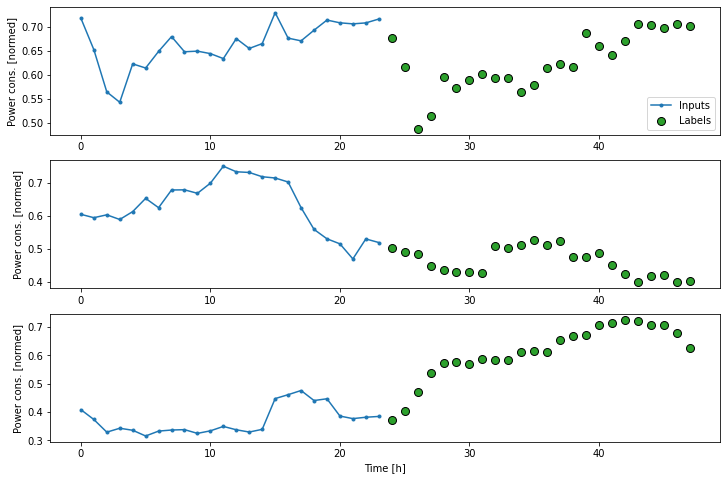

In [33]:
OUT_STEPS = OUTPUT_STEP_COUNT
multi_window = WindowGenerator(input_width=INPUT_STEP_COUNT,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Univariate Multi Step window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Power consumption (kWh)']

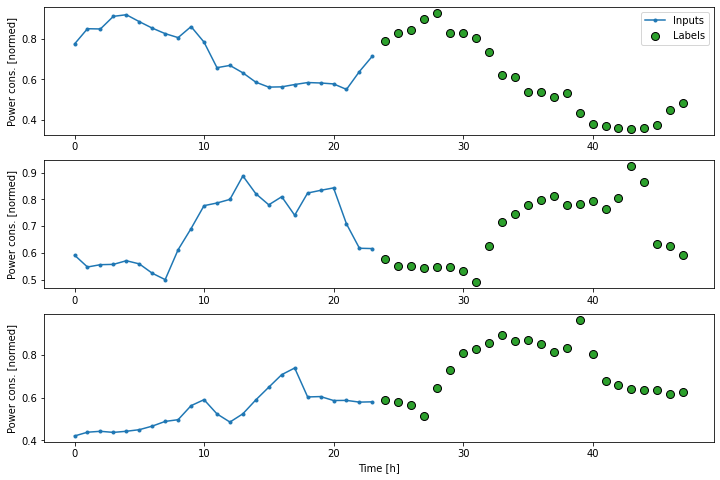

In [34]:
uni_multi_window = WindowGenerator(input_width=INPUT_STEP_COUNT,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=OUTPUT_COLUMN_NAMES)

uni_multi_window.plot()
uni_multi_window

# Update Model Metrics Function

In [35]:
def getOuputSlice(self, label_col=PRIMARY_OUTPUT_COLUMN, inverse=False):
    active_window = self.active_window if hasattr(self, "active_window") else multi_window
    if active_window.label_columns:
        label_col_index = active_window.label_columns_indices.get(label_col, None)
    else:
        label_col_index = active_window.column_indices[label_col]

    if label_col_index is None:
        label_col_index = NUM_FEATURES - 1
    if not inverse:
        return slice(label_col_index, label_col_index + 1)
    else:
        return slice(0, label_col_index), slice(label_col_index + 1, None)
    
tf.keras.Model.getOuputSlice = getOuputSlice

In [36]:
def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        
        output_slice = self.getOuputSlice()
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred[:,:,output_slice])
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

default_train_step = tf.keras.Model.train_step
tf.keras.Model.train_step = train_step

In [37]:
def test_step(self, data):
        # Unpack the data
        x, y = data
        
        output_slice = self.getOuputSlice()
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred[:,:,output_slice])
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

default_test_step = tf.keras.Model.test_step
tf.keras.Model.test_step = test_step

# Generate Performance Baselines

## Last Input Baseline

### Define Model

In [38]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

### Instantiate and evaluate model

In [39]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}
multi_train_performance = {}

multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0885 - mean_absolute_error: 0.1066


### Graph results

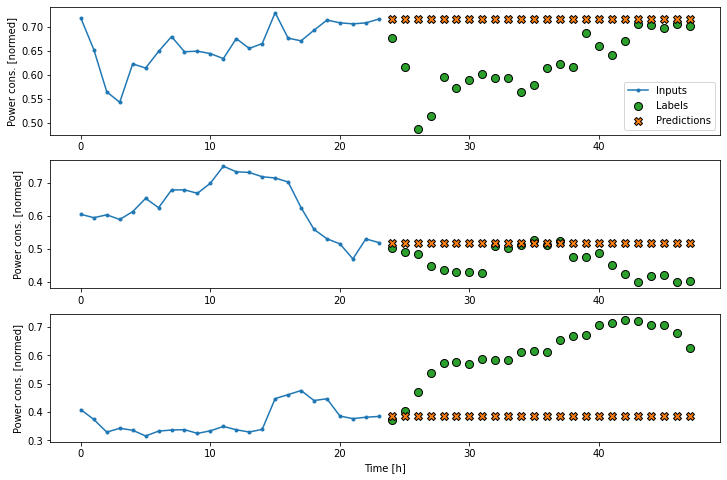

In [40]:
# the baseline is simply predicting the next values to be the past value as can be seen in the graph
multi_window.plot(last_baseline)

## Repeat Baseline

### Define Model

In [41]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

### Instantiate and evaluate model

In [42]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_train_performance['Repeat'] = repeat_baseline.evaluate(multi_window.train)
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0403 - mean_absolute_error: 0.0990


### Graph results

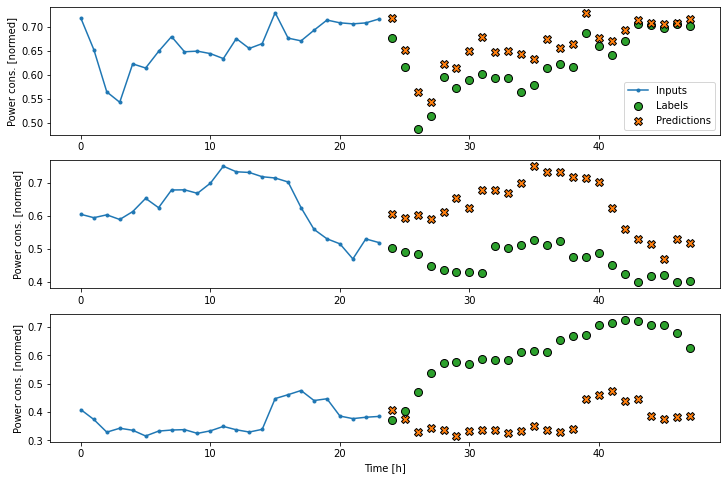

In [43]:
# the baseline is repeating previous window
multi_window.plot(repeat_baseline)

# Single-shot models

## Generate Linear Model

### Define Model

In [44]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
])

### Instantiate and evaluate model

In [45]:
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Linear'] = multi_linear_model.evaluate(multi_window.train)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0426 - mean_absolute_error: 0.0864


### Graph result

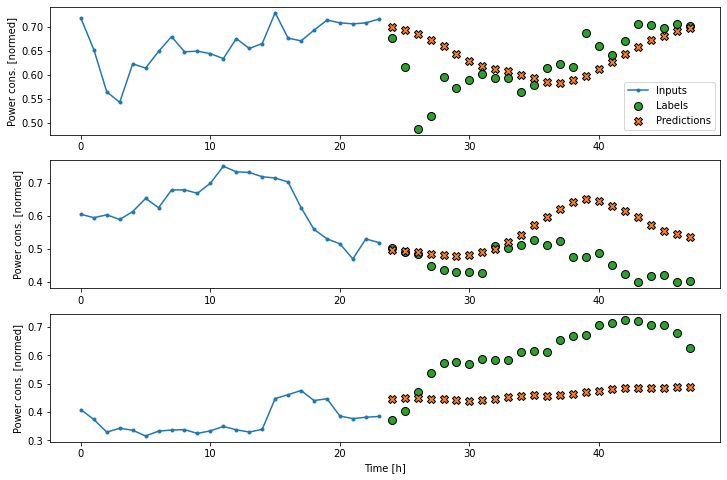

In [46]:
multi_window.plot(multi_linear_model)

## Generate Dense Model

### Define Model

In [47]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
])

### Instantiate and evaluate model

In [48]:
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Dense'] = multi_dense_model.evaluate(multi_window.train)
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: 0.0243 - mean_absolute_error: 0.0804


### Graph result

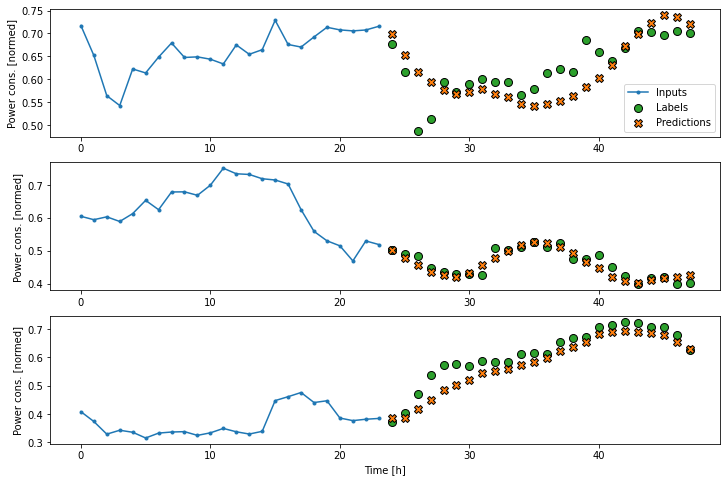

In [49]:
multi_window.plot(multi_dense_model)

## Generate Convolutional Neural Network Model

### Define Model

In [50]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
])

### Instantiate and evaluate model

In [51]:
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: 0.0272 - mean_absolute_error: 0.0911


### Graph result

Text(0.5, 3.4, 'Given 24 hours of inputs, predict 24 hours into the future.')

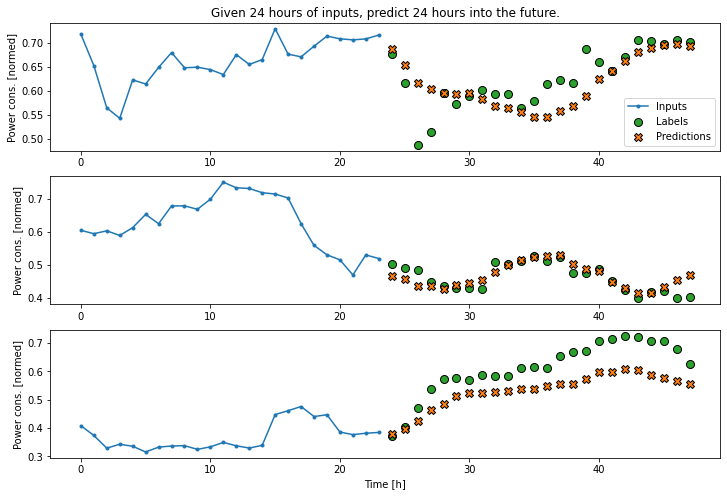

In [52]:
multi_window.plot(multi_conv_model)
plt.title(f"Given {INPUT_STEP_COUNT} hours of inputs, predict {OUTPUT_STEP_COUNT} hours into the future.", y=3.4)

## Generate Recurrent Neural Network Model

### Define Model

In [53]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
])

### Instantiate and evaluate model

In [54]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 3ms/step - loss: 0.0196 - mean_absolute_error: 0.0767


### Graph result

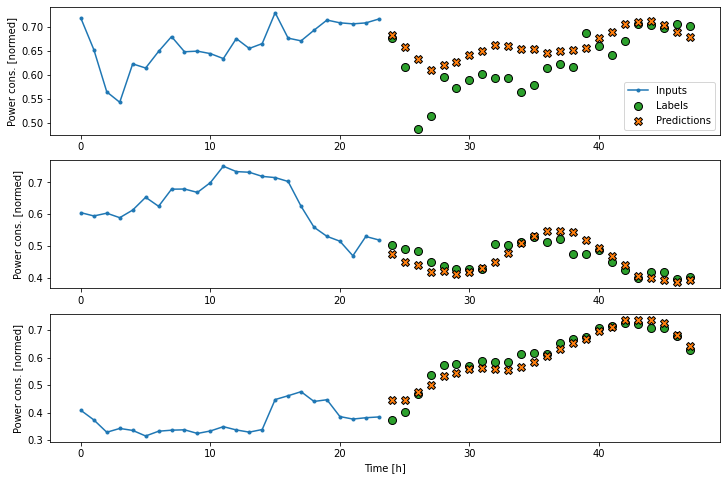

In [55]:
multi_window.plot(multi_lstm_model)

## Generate Residual Connections LSTM Model

### Create wrapper model class

In [56]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

### Define model

In [57]:
multi_residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
]))

### Instantiate and evaluate model

In [58]:
history = compile_and_fit(multi_residual_lstm, multi_window)

IPython.display.clear_output()

multi_train_performance['Residual LSTM'] = multi_residual_lstm.evaluate(multi_window.train)
multi_val_performance['Residual LSTM'] = multi_residual_lstm.evaluate(multi_window.val)
multi_performance['Residual LSTM'] = multi_residual_lstm.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0492


### Graph result

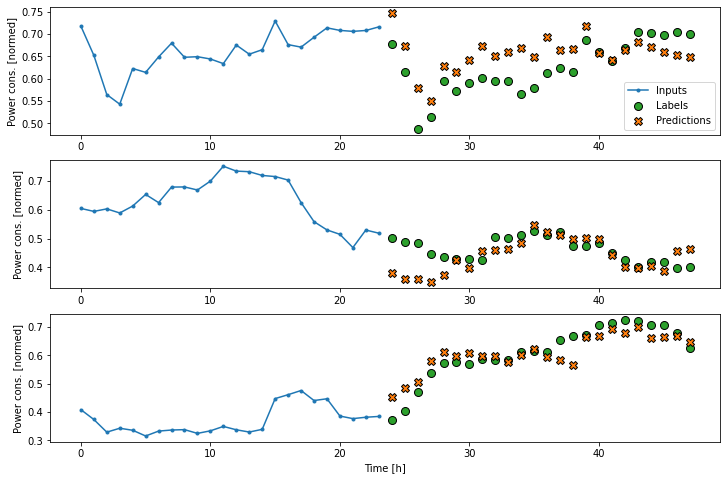

In [59]:
multi_window.plot(multi_residual_lstm)

## Generate Complex Recurrent Neural Network Model

### Create wrapper model class

In [60]:
class IdentityWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        output = self.model(inputs, *args, **kwargs)
        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return output

In [61]:
IdentityWrapper.train_step = default_train_step
IdentityWrapper.test_step = default_test_step

### Define Model

In [62]:
complex_out_features = NUM_FEATURES
complex_multi_lstm_model = IdentityWrapper(
    tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(16, return_sequences=False),
        tf.keras.layers.Dropout(0.05),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS),
        tf.keras.layers.Reshape([OUT_STEPS, 1])
    ])
)

### Instantiate and evaluate model

In [63]:
history = compile_and_fit(complex_multi_lstm_model, uni_multi_window)

IPython.display.clear_output()

multi_train_performance['Complex LSTM'] = complex_multi_lstm_model.evaluate(uni_multi_window.train)
multi_val_performance['Complex LSTM'] = complex_multi_lstm_model.evaluate(uni_multi_window.val)
multi_performance['Complex LSTM'] = complex_multi_lstm_model.evaluate(uni_multi_window.test, verbose=0)

54/54 [==============================] - 0s 4ms/step - loss: 0.0094 - mean_absolute_error: 0.0736


### Graph result

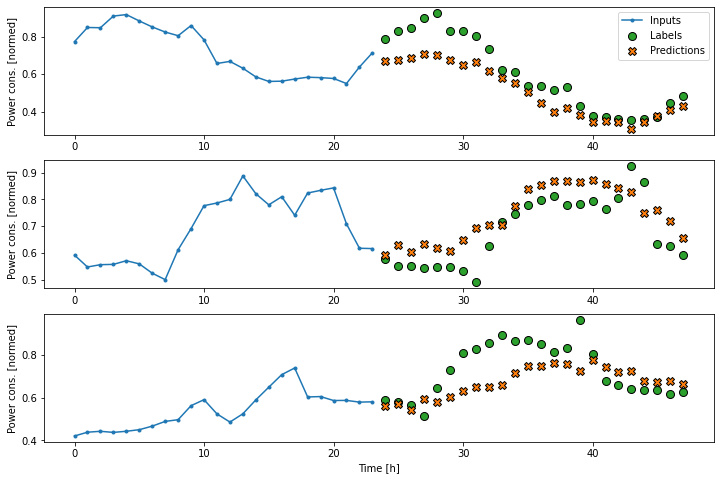

In [64]:
uni_multi_window.plot(complex_multi_lstm_model)

# Autoregressive Models

## Generate Basic Autoregressive LSTM Model

### Define model

In [65]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(NUM_FEATURES)

In [66]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [67]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [68]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 7])

In [69]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [70]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 7)


### Instantiate and evaluate model

In [71]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_train_performance['AR LSTM'] = feedback_model.evaluate(multi_window.train)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 4ms/step - loss: 0.0365 - mean_absolute_error: 0.1023


### Graph result

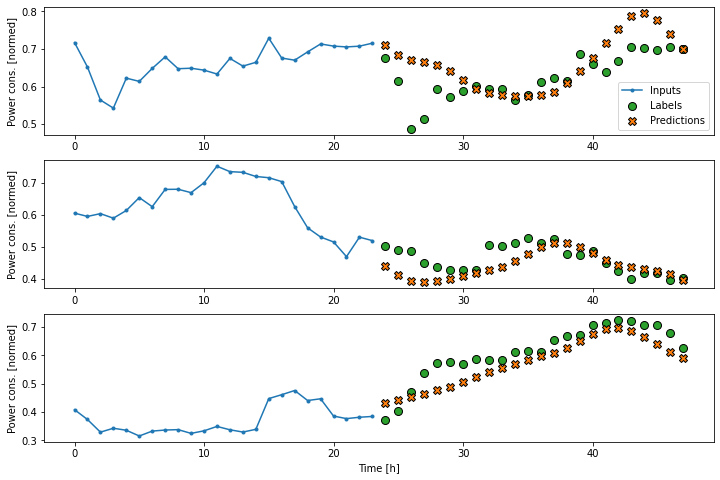

In [72]:
multi_window.plot(feedback_model)

## Generate Univariate Autoregressive LSTM Model

### Define model

In [73]:
class UnivariateFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

In [74]:
univariate_feedback_model = UnivariateFeedBack(units=32, out_steps=OUT_STEPS)

In [75]:
def univariate_warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

UnivariateFeedBack.univariate_warmup = univariate_warmup

In [76]:
prediction, state = univariate_feedback_model.univariate_warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [77]:
def call(self, inputs, outputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.univariate_warmup(inputs)
    
    output_slice = self.getOuputSlice(inverse=True)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x_out = outputs[:,n - 1,:]
        x = tf.concat([x_out[:,output_slice[0]], 
                   prediction, x_out[:,output_slice[1]]], 
                  axis=1)
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

UnivariateFeedBack.call = call

In [78]:
def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        
        output_slice = self.getOuputSlice()

        with tf.GradientTape() as tape:
            y_pred = self(x, y, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
UnivariateFeedBack.train_step = train_step

In [79]:
def test_step(self, data):
        # Unpack the data
        x, y = data
        
        output_slice = self.getOuputSlice()
            
        # Compute predictions
        y_pred = self(x, y, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
UnivariateFeedBack.test_step = test_step

In [80]:
print('Output shape (batch, time, features): ', univariate_feedback_model(multi_window.example[0], multi_window.example[1]).shape)

Output shape (batch, time, features):  (32, 24, 1)


### Instantiate and evaluate model

In [81]:
history = compile_and_fit(univariate_feedback_model, multi_window)

IPython.display.clear_output()

multi_train_performance['Uni AR LSTM'] = univariate_feedback_model.evaluate(multi_window.train)
multi_val_performance['Uni AR LSTM'] = univariate_feedback_model.evaluate(multi_window.val)
multi_performance['Uni AR LSTM'] = univariate_feedback_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_absolute_error: 0.0724


### Graph result

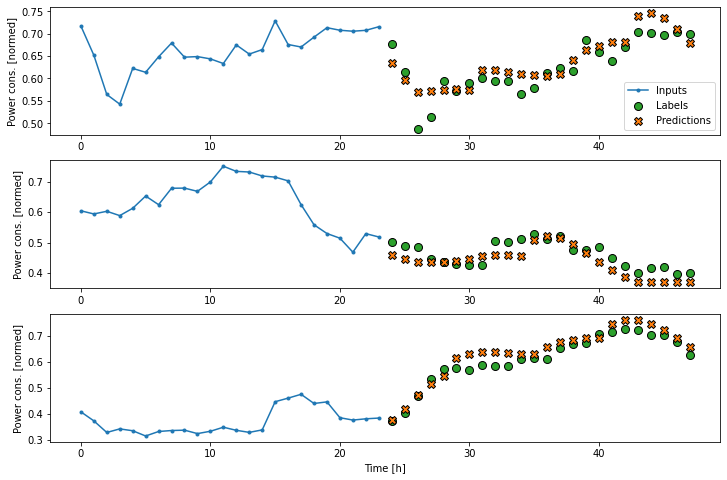

In [82]:
multi_window.plot(univariate_feedback_model, model_uses_labels=True, univariate=True)

## Generate Residual Univariate Autoregressive LSTM Model

### Define model

In [83]:
class DropoutResidualUnivariateFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        # NOTE: with dropout
        self.lstm_cell = tf.keras.layers.LSTMCell(units=units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.model = Sequential([
            tf.keras.layers.Dense(units=1, kernel_initializer=tf.initializers.zeros())
        ]) 

In [84]:
univariate_feedback_model = DropoutResidualUnivariateFeedBack(units=32, out_steps=OUT_STEPS)

In [85]:
def univariate_warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    # predictions.shape => (batch, features)
    prediction = self.model(x)
    return prediction, state

DropoutResidualUnivariateFeedBack.univariate_warmup = univariate_warmup

In [86]:
prediction, state = univariate_feedback_model.univariate_warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [87]:
def call(self, inputs, outputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    delta, state = self.univariate_warmup(inputs)
    
    output_slice = self.getOuputSlice()
    split_output_slice = self.getOuputSlice(inverse=True)

    # Insert the first prediction.
    prediction = inputs[:,-1,output_slice] + delta
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x_out = outputs[:,n - 1,:]
        x = tf.concat([x_out[:,split_output_slice[0]], 
                   prediction, x_out[:,split_output_slice[1]]], 
                  axis=1)
        
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        delta = self.model(x)
        prediction = prediction + delta
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

DropoutResidualUnivariateFeedBack.call = call

In [88]:
def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        
        output_slice = self.getOuputSlice()

        with tf.GradientTape() as tape:
            y_pred = self(x, y, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
DropoutResidualUnivariateFeedBack.train_step = train_step

In [89]:
def test_step(self, data):
        # Unpack the data
        x, y = data
        
        output_slice = self.getOuputSlice()
            
        # Compute predictions
        y_pred = self(x, y, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
DropoutResidualUnivariateFeedBack.test_step = test_step

In [90]:
print('Output shape (batch, time, features): ', univariate_feedback_model(multi_window.example[0], multi_window.example[1]).shape)

Output shape (batch, time, features):  (32, 24, 1)


### Instantiate and evaluate model

In [91]:
history = compile_and_fit(univariate_feedback_model, multi_window)

IPython.display.clear_output()

multi_train_performance['DR AR LSTM'] = univariate_feedback_model.evaluate(multi_window.train)
multi_val_performance['DR AR LSTM'] = univariate_feedback_model.evaluate(multi_window.val)
multi_performance['DR AR LSTM'] = univariate_feedback_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0677


### Graph result

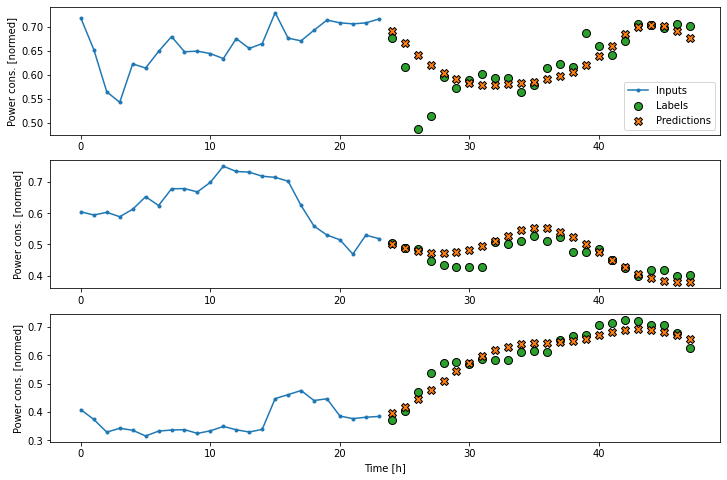

In [92]:
multi_window.plot(univariate_feedback_model, model_uses_labels=True, univariate=True)

## Generate Dropout Residual Univariate Autoregressive LSTM Model

### Define model

In [93]:
class DropoutResidualUnivariateFeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        # NOTE: with dropout
        self.lstm_cell = tf.keras.layers.LSTMCell(units=units, dropout=0.2, recurrent_dropout=0.2)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.model = Sequential([
            tf.keras.layers.Dense(units=1, kernel_initializer=tf.initializers.zeros())
        ]) 

In [94]:
univariate_feedback_model = DropoutResidualUnivariateFeedBack(units=32, out_steps=OUT_STEPS)

In [95]:
def univariate_warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs, training=True)
    
    # predictions.shape => (batch, features)
    prediction = self.model(x)
    return prediction, state

DropoutResidualUnivariateFeedBack.univariate_warmup = univariate_warmup

In [96]:
prediction, state = univariate_feedback_model.univariate_warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [97]:
def call(self, inputs, outputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    delta, state = self.univariate_warmup(inputs)
    
    output_slice = self.getOuputSlice()
    split_output_slice = self.getOuputSlice(inverse=True)

    # Insert the first prediction.
    prediction = inputs[:,-1,output_slice] + delta
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x_out = outputs[:,n - 1,:]
        x = tf.concat([x_out[:,split_output_slice[0]], 
                   prediction, x_out[:,split_output_slice[1]]], 
                  axis=1)
        
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        delta = self.model(x)
        prediction = prediction + delta
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

DropoutResidualUnivariateFeedBack.call = call

In [98]:
def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        
        output_slice = self.getOuputSlice()

        with tf.GradientTape() as tape:
            y_pred = self(x, y, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
DropoutResidualUnivariateFeedBack.train_step = train_step

In [99]:
def test_step(self, data):
        # Unpack the data
        x, y = data
        
        output_slice = self.getOuputSlice()
            
        # Compute predictions
        y_pred = self(x, y, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y[:,:,output_slice], y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y[:,:,output_slice], y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
DropoutResidualUnivariateFeedBack.test_step = test_step

In [100]:
print('Output shape (batch, time, features): ', univariate_feedback_model(multi_window.example[0], multi_window.example[1]).shape)

Output shape (batch, time, features):  (32, 24, 1)


### Instantiate and evaluate model

In [101]:
history = compile_and_fit(univariate_feedback_model, multi_window)

IPython.display.clear_output()

multi_train_performance['DRU AR LSTM'] = univariate_feedback_model.evaluate(multi_window.train)
multi_val_performance['DRU AR LSTM'] = univariate_feedback_model.evaluate(multi_window.val)
multi_performance['DRU AR LSTM'] = univariate_feedback_model.evaluate(multi_window.test, verbose=0)

54/54 [==============================] - 0s 8ms/step - loss: 0.0121 - mean_absolute_error: 0.0847


### Graph result

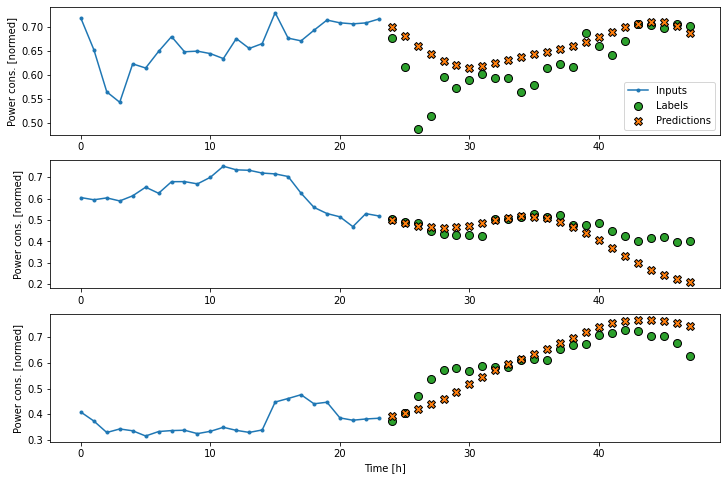

In [102]:
multi_window.plot(univariate_feedback_model, model_uses_labels=True, univariate=True)

# Compare Models

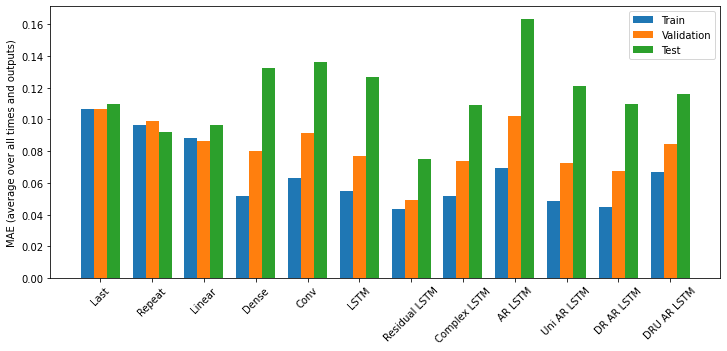

In [103]:
x = np.arange(len(multi_performance))
width = 0.25

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')

train_mae = [v[metric_index] for v in multi_train_performance.values()]
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(12, 5))  
plt.bar(x - 0.251, train_mae, width, label='Train')
plt.bar(x, val_mae, width, label='Validation')
plt.bar(x + 0.251, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [104]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.1098
Repeat  : 0.0921
Linear  : 0.0967
Dense   : 0.1326
Conv    : 0.1361
LSTM    : 0.1270
Residual LSTM: 0.0749
Complex LSTM: 0.1090
AR LSTM : 0.1631
Uni AR LSTM: 0.1213
DR AR LSTM: 0.1099
DRU AR LSTM: 0.1160


In [105]:
for name, value in multi_train_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.1067
Repeat  : 0.0967
Linear  : 0.0885
Dense   : 0.0516
Conv    : 0.0633
LSTM    : 0.0548
Residual LSTM: 0.0438
Complex LSTM: 0.0520
AR LSTM : 0.0693
Uni AR LSTM: 0.0484
DR AR LSTM: 0.0448
DRU AR LSTM: 0.0670
